In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = amp.GradScaler()  # For mixed precision

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

/tmp/ipykernel_23/1629676082.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()  # For mixed precision
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=50):
    model.train()
    best_val_accuracy = 0.0
    best_model_wts = None

    for epoch in range(epochs):
        total_train_loss = 0
        correct_train = 0
        total_train = 0
        print('train : ', epoch)

        model.train()  # Ensure model is in training mode
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = torch.nn.functional.one_hot(labels, num_classes=2).float()  # Convert to one-hot

            optimizer.zero_grad()

            with amp.autocast():  # Mixed precision context
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                predicted = torch.argmax(outputs, dim=1)
                correct_train += (predicted == labels.argmax(dim=1)).sum().item()
                total_train += labels.size(0)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_train_loss += loss.item() * inputs.size(0)

        train_loss = total_train_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = torch.nn.functional.one_hot(labels, num_classes=2).float()  # Convert to one-hot

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                predicted = torch.argmax(outputs, dim=1)
                correct_val += (predicted == labels.argmax(dim=1)).sum().item()
                total_val += labels.size(0)
                total_val_loss += loss.item() * inputs.size(0)

        val_loss = total_val_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct_val / total_val

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        # Check if this is the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_wts = model.state_dict()

    print('Training complete')

    # Load best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)
        torch.save(model.state_dict(), 'colon-dtcwt-level-1-128-visu.pth')
        print(f'Best model saved with validation accuracy: {best_val_accuracy:.2f}%')

train_model(model, criterion, optimizer, train_loader, val_loader)

/tmp/ipykernel_23/4074348938.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


train :  0


/tmp/ipykernel_23/3944520582.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():  # Mixed precision context


Epoch 1/50, Train Loss: 0.4481, Train Acc: 81.12%, Val Loss: 0.8022, Val Acc: 63.50%
train :  1
Epoch 2/50, Train Loss: 0.1018, Train Acc: 97.67%, Val Loss: 0.3540, Val Acc: 86.50%
train :  2
Epoch 3/50, Train Loss: 0.0460, Train Acc: 98.71%, Val Loss: 0.6882, Val Acc: 76.40%
train :  3
Epoch 4/50, Train Loss: 0.0268, Train Acc: 99.28%, Val Loss: 0.0991, Val Acc: 96.50%
train :  4
Epoch 5/50, Train Loss: 0.0165, Train Acc: 99.62%, Val Loss: 0.5083, Val Acc: 83.00%
train :  5
Epoch 6/50, Train Loss: 0.0322, Train Acc: 98.83%, Val Loss: 0.6070, Val Acc: 77.60%
train :  6
Epoch 7/50, Train Loss: 0.0167, Train Acc: 99.52%, Val Loss: 0.5033, Val Acc: 84.10%
train :  7
Epoch 8/50, Train Loss: 0.0103, Train Acc: 99.76%, Val Loss: 1.2578, Val Acc: 67.40%
train :  8
Epoch 9/50, Train Loss: 0.0076, Train Acc: 99.78%, Val Loss: 0.0224, Val Acc: 99.00%
train :  9
Epoch 10/50, Train Loss: 0.0074, Train Acc: 99.84%, Val Loss: 0.1286, Val Acc: 96.20%
train :  10
Epoch 11/50, Train Loss: 0.0057, Train

/tmp/ipykernel_23/4074348938.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


Test Loss: 0.0216, Test Accuracy: 99.30%
Confusion Matrix:
[[494   6]
 [  1 499]]


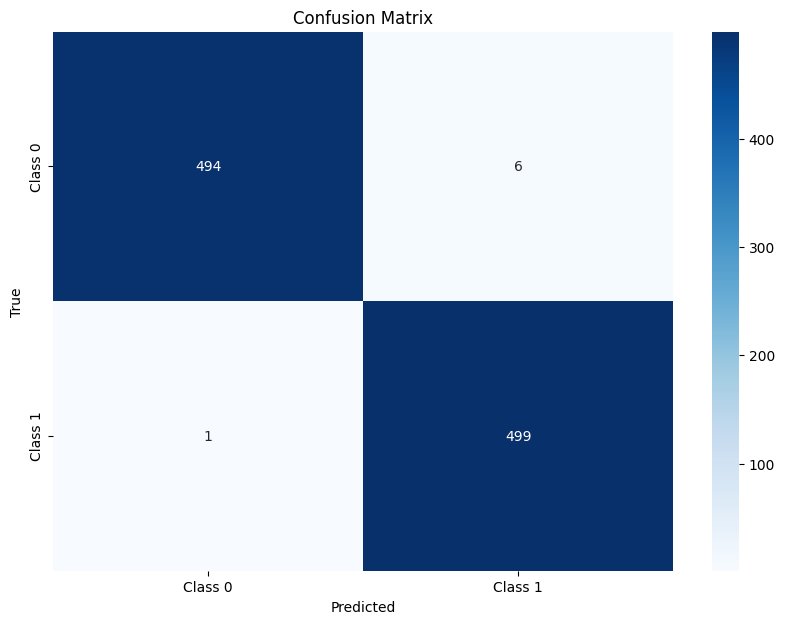

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.99      0.99       500
     Class 1       0.99      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_and_print_confusion_matrix(model, test_loader):
    model.eval()
    correct_test = 0
    total_test = 0
    total_test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # One-hot encode the labels
            one_hot_labels = F.one_hot(labels, num_classes=2).float()

            outputs = model(inputs)
            loss = criterion(outputs, one_hot_labels)
            _, predicted = torch.max(outputs.data, 1)

            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)
            total_test_loss += loss.item() * inputs.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = total_test_loss / len(test_loader.dataset)
    test_accuracy = 100 * correct_test / total_test
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot confusion matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    class_report = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1'])
    print("Classification Report:")
    print(class_report)

evaluate_model_and_print_confusion_matrix(model, test_loader)

/tmp/ipykernel_23/4074348938.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.323s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.196365
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.004669
[t-SNE] KL divergence after 300 iterations: 0.468948


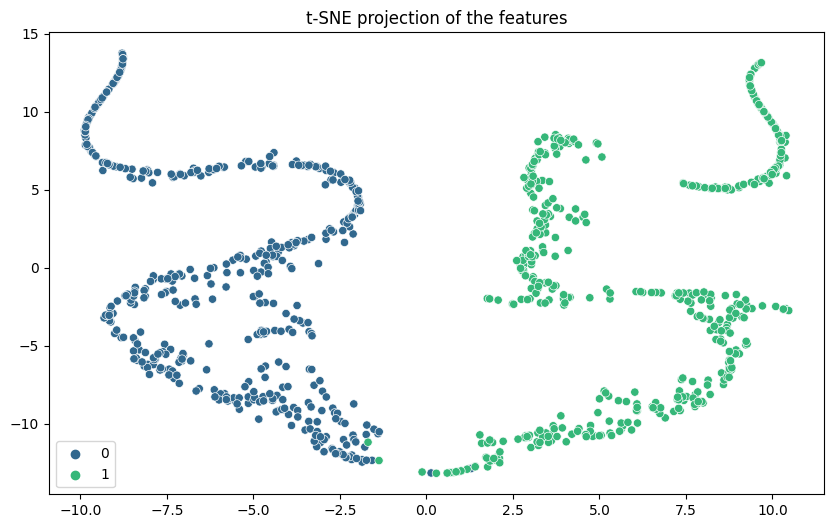

In [ ]:
def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            # Manually forward up to a safe point before the problematic layers
            x = model.conv1(imgs)
            x = model.maxpool(x)
            x = model.stages(x)  # Assuming stages can be computed without error
            x = model.conv5(x)
            x = model.g_avg_pool(x)
            x = x.view(x.size(0), -1)  # Flatten the features
            features.append(x.cpu())
            labels.extend(lbls)

    features = torch.cat(features, dim=0)
    labels = np.array(labels)
    return features.numpy(), labels

def plot_tsne(features, labels):
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(features)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette='viridis', legend='full')
    plt.title('t-SNE projection of the features')
    plt.show()

# Usage:
features, labels = extract_features(model, test_loader)
plot_tsne(features, labels)